In [2]:
# Install everything you need in one go
!pip install -q \
    numpy scipy matplotlib tqdm pandas \
    pims trackpy tifffile \
    pymc arviz \
    scikit-image opencv-python \
    pydrive2

!pip install numpyro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.7/132.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.8/365.8 kB 7.5 MB/s eta 0:00:00


In [3]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os, pims

# 1) Authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# 2) Download TIFFs from your shared folder into ./tifs/
folder_id = "1vY57qhwxVeRelL9DkGpBiVvFKTgmO8cn"
os.makedirs("tifs", exist_ok=True)
for f in drive.ListFile({
        'q': f"'{folder_id}' in parents and trashed=false"
    }).GetList():
    if f['title'].lower().endswith('.tif'):
        f.GetContentFile(os.path.join("tifs", f['title']))

# 3) Load with pims
NIST_folder = "tifs/"
filtered = sorted([
    os.path.join(NIST_folder, fn)
    for fn in os.listdir(NIST_folder)
    if fn.lower().endswith('.tif') and int(fn[18:21]) >= 19
])
raw_test = pims.ImageSequence(filtered)
print(f"Loaded {len(raw_test)} frames.")

Loaded 132 frames.


/usr/local/lib/python3.11/dist-packages/pims/image_sequence.py:85: FutureWarning: The plugin infrastructure in `skimage.io` and the parameter `plugin` are deprecated since version 0.25 and will be removed in 0.27 (or later). To avoid this warning, please do not use the parameter `plugin`. Instead, use `imageio` or other I/O packages directly. See also `imread`.
  return imread(filename, **kwargs)


In [4]:
# defaults for Python
import numpy as np
import pandas as pd               # TrackPy results are stored in Pandas dataframes
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# TrackPy stuff
import trackpy as tp
import pims

# annoying pims warning
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# gamma adjust stuff
from skimage.exposure import adjust_gamma
import tifffile

# writing to mp4
import cv2

import os

from scipy import stats

from tqdm import tqdm

# forcing nano scale
from matplotlib.ticker import ScalarFormatter
nano_formatter = ScalarFormatter(useMathText=True)
nano_formatter.set_powerlimits((-9, -9))  # Force e-9

import pymc as pm
import arviz as az

**NOTE:** max sim signal of 799

### Helper functions

In [5]:
# frame adjustment function (based on NIST function):
def adjust_frame(frame, gamma=2, clip_quantile=0.9999):
    tmp = frame.copy().astype(np.float32)
    tmp[tmp > np.quantile(tmp, clip_quantile)] = np.quantile(tmp, clip_quantile)
    #print(np.max(tmp))
    #tmp /= np.max(tmp)
    tmp = adjust_gamma(tmp, gamma)
    #plt.imshow(frame, cmap="grey")
    #plt.show()
    # note that many times values are greater than 65,535
    tmp = np.clip(tmp, 0, 65535).astype(np.uint16)
    return tmp

def overlay(locations, image):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.imshow(image, cmap='gray')

    for _, row in locations.iterrows():
        circ = Circle((row['x'], row['y']), radius=20, edgecolor='red', facecolor='none', linewidth=1)
        ax.add_patch(circ)

    plt.show()

def export_annotated_video(tracks, frames, output_path, numbers=True, fps=10, frame_num=True):
    # Make sure x, y are floats
    tracks['x'] = tracks['x'].astype(float)
    tracks['y'] = tracks['y'].astype(float)

    # Setup video writer
    frame_size = (frames.frame_shape[1], frames.frame_shape[0])  # width, height
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    writer = cv2.VideoWriter(output_path, fourcc, fps, frame_size, isColor=True)

    # Normalization and convert to 8bit
    def normalize_and_8bit(img):
        img = img.astype(np.float32)
        img /= img.max() if img.max() > 0 else 1
        return (img * 255).astype(np.uint8)

    # go through and annotate all frames
    for i, frame in enumerate(frames):
        img = normalize_and_8bit(frame)

        # Convert to BGR for drawing (required by OpenCV)
        img_bgr = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)

        # draw frame number if option is true
        if frame_num:
            cv2.putText(img_bgr, "frame: " + str(i), (20, 500), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        # Draw particle circles for current frame (add numbers if parameter is true)
        particles = tracks[tracks['frame'] == i]
        if numbers == True:
            for _, row in particles.iterrows():
                x, y = int(row['x']), int(row['y'])
                cv2.circle(img_bgr, (x, y), radius=20, color=(0, 0, 255), thickness=3)
                cv2.putText(img_bgr, str(int(row['particle'])), (x+20, y+10), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)

        else:
            for _, row in particles.iterrows():
                x, y = int(row['x']), int(row['y'])
                cv2.circle(img_bgr, (x, y), radius=20, color=(0, 0, 255), thickness=3)

        # Write frame
        writer.write(img_bgr)

    writer.release()
    print(f"Saved to {output_path}")

def display_particle(tracks, img, particle_number, frame_number, radius):

    particle_track = tracks[tracks['particle'] == particle_number]

    particle_frame = particle_track[particle_track['frame'] == frame_number]
    x, y = int(round(particle_frame['x'])), int(round(particle_frame['y']))

    x_min = max(0, x - radius)
    x_max = min(img.shape[1], x + radius)
    y_min = max(0, y - radius)
    y_max = min(img.shape[0], y + radius)

    square = img[y_min:y_max, x_min:x_max]

    # Create grid for surface plot
    x_range = np.arange(square.shape[1])  # width
    y_range = np.arange(square.shape[0])  # height
    X, Y = np.meshgrid(x_range, y_range)

    # Z is intensity
    Z = square

    # Plot 3D surface
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    fig.colorbar(surf, ax=ax, shrink=0.5, aspect=10, label='Pixel Intensity')

    ax.set_title(f"particle {particle_number}, x : {x}, y:{y}")
    ax.set_xlabel('X (pixels)')
    ax.set_ylabel('Y (pixels)')
    ax.set_zlabel('Intensity')

    plt.tight_layout()
    plt.show()

# Read raw NIST data

In [6]:
import os, pims

# Point directly at the folder containing your .tif files
NIST_folder = "tifs/"

# Sanity check: list a few files so you know it’s the right place
print("Contents of", NIST_folder, ":", os.listdir(NIST_folder)[:10])

# Filter only files ≥ frame 19
filtered_NISTs = [
    os.path.join(NIST_folder, fn)
    for fn in os.listdir(NIST_folder)
    if fn.lower().endswith('.tif') and int(fn[18:21]) >= 19
]

# Load into a PIMS sequence
raw_test = pims.ImageSequence(sorted(filtered_NISTs))
print("Loaded", len(raw_test), "frames.")


Contents of tifs/ : ['1. Fluo_0.1s_mid_t023_ORG.tif', '1. Fluo_0.1s_mid_t064_ORG.tif', '1. Fluo_0.1s_mid_t128_ORG.tif', '1. Fluo_0.1s_mid_t150_ORG.tif', '1. Fluo_0.1s_mid_t046_ORG.tif', '1. Fluo_0.1s_mid_t054_ORG.tif', '1. Fluo_0.1s_mid_t014_ORG.tif', '1. Fluo_0.1s_mid_t081_ORG.tif', '1. Fluo_0.1s_mid_t106_ORG.tif', '1. Fluo_0.1s_mid_t117_ORG.tif']
Loaded 132 frames.


## Adjust raw data to take neighbor's mean for pixels over a threshold

In [7]:
mean_adjusted_folder = "mean_adjusted"
os.makedirs(mean_adjusted_folder, exist_ok=True)

threshold = 2000

mean_adjusted_frames = []

for i, frame in enumerate(raw_test):
    coords = np.argwhere(frame > threshold)

    for y, x in coords:
        # only do for the one hot pixel
        if ((x,y) != (875, 610)):
            #print(x,y)
            continue

        y_min, y_max = max(0, y - 1), min(2048, y + 2)
        x_min, x_max = max(0, x - 1), min(2048, x + 2)

        neighborhood = frame[y_min:y_max, x_min:x_max]
        neighborhood = neighborhood.flatten()
        neighbors = neighborhood[neighborhood < threshold]

        frame[y, x] = int(np.mean(neighbors))

    #print(np.max(frame))

    frame_output_path = os.path.join(mean_adjusted_folder, f"mean_adjusted_{threshold}_frame{i:04d}.tif")

    tifffile.imwrite(frame_output_path, frame, dtype=frame.dtype)


##### load mean adjusted sequence

In [8]:
test = pims.open(f"{mean_adjusted_folder}/*.tif")

#### Make gamma adjusted for TrackPy visualizations

In [9]:
gamma_adjusted_folder = "gamma_adjusted"
os.makedirs(gamma_adjusted_folder, exist_ok=True)
for i, frame in enumerate(test):
    processed = adjust_frame(frame, gamma=2, clip_quantile=0.9999)
    #print(np.max(frame), np.max(processed), processed.dtype)
    #print(((processed != 0) & (processed != 1)).sum())
    #percentiles(processed)
    tifffile.imwrite(f"{gamma_adjusted_folder}/frame_{i:04d}.tif", processed)

In [10]:
test_adjusted = pims.open(f"{gamma_adjusted_folder}/*.tif")

# Fit simulation parameters to test data

Mean adjusted test data is stored in "test" pims sequence

Fit parameters to be used in image generation


## Fit backgound noise

Fit background noise with a simple guassian of the pixel values below a threshold percentile

Over the sequence of images, take the average mu and sigma

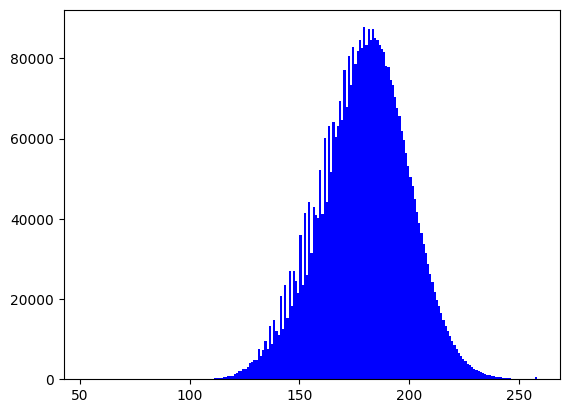

In [11]:
## create background noise image based on clipping

clip_quantile = 0.9999
noise_clip = np.asarray(test[0])
noise_clip[noise_clip > np.quantile(noise_clip, clip_quantile)] = np.quantile(noise_clip, clip_quantile)

hist_min = np.min(noise_clip)
hist_max = np.max(noise_clip)
plt.hist(noise_clip.ravel(), bins=int(hist_max - hist_min), range=(hist_min, hist_max), color='blue')
plt.show()

#### go through entire sequence

In [12]:
fitted_mus = []
fitted_sigmas =[]
KS_ps = []

for frame in tqdm(test):
    clip_quantile = 0.9999
    noise_clip = np.asarray(frame)
    noise_clip[noise_clip > np.quantile(noise_clip, clip_quantile)] = np.quantile(noise_clip, clip_quantile)

    mu, sigma = stats.norm.fit(noise_clip)

    ks_stat, ks_p = stats.kstest(noise_clip.ravel(), 'norm', args=(mu, sigma))

    fitted_mus.append(mu)
    fitted_sigmas.append(sigma)
    KS_ps.append(ks_p)

100%|██████████| 132/132 [01:28<00:00,  1.49it/s]


In [13]:
#plt.plot(fitted_mus)

In [14]:
#plt.plot(fitted_sigmas)

In [15]:
#plt.plot(KS_ps)

In [16]:
fitted_noise_mu = np.mean(np.array(fitted_mus))
fitted_noise_sigma = np.mean(np.array(fitted_sigmas))

print("Background noise fit:")
print("mu:", fitted_noise_mu)
print("sigma:", fitted_noise_sigma)

Background noise fit:
mu: 177.19257854151004
sigma: 19.62560467837437


## Fit guassian blurs of particles

Go through strong TrackPy particle detections


##### Make TrackPy Predictions

In [17]:
video_features = tp.batch(test, diameter=23, minmass=1200);

Frame 131: 27 features


In [18]:
raw_tracks = tp.link(video_features, search_range=20, memory=3)
tracks = tp.filter_stubs(raw_tracks, 20)

Frame 131: 27 trajectories present.


#### Choose Strong Track Identifications to fit

Look at exported track video to choose by hand

For now, I'm just going to use particles that are always present

In [19]:
export_annotated_video(tracks, test_adjusted, "normal_test_adjusted_annotated.mp4", numbers=True, fps=3)

Saved to normal_test_adjusted_annotated.mp4


In [20]:
# get particle nums with detection at every frame:
num_frames = len(tracks['frame'].unique())

full_particles = []
for particle in tracks['particle'].unique():
    particle_df = tracks[tracks["particle"] == particle]

    if len(particle_df) == num_frames:
        full_particles.append(int(particle))

print("Always present particles:", full_particles)

Always present particles: [4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 22, 25, 26, 27, 28, 29, 30, 31]


In [21]:
# looking at exported track video, choose a couple strong predictions
#strong_particle_nums = [19, 17, 20, 1, 7]

column_num = 4

strong_particle_nums = full_particles.copy()
strong_particle_nums.remove(column_num)

strong_tracks = tracks[tracks['particle'].isin(strong_particle_nums)]

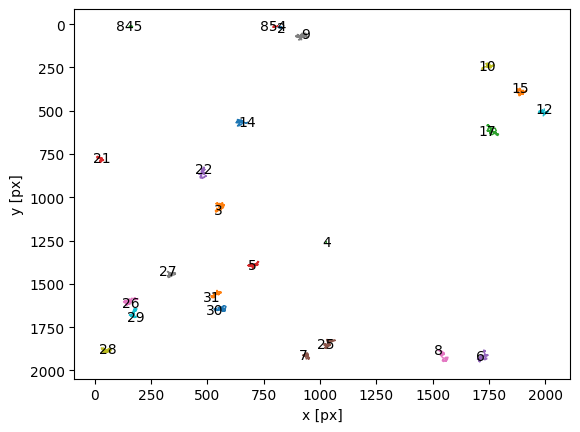

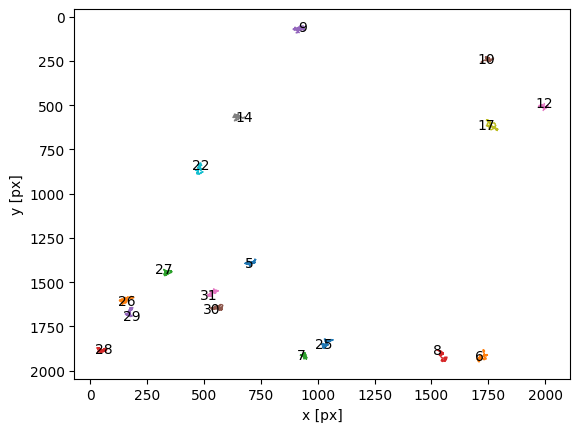

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [22]:
tp.plot_traj(tracks, label=True)
tp.plot_traj(strong_tracks, label=True)

#### Fit strong identifications

Go through chosen strong tracks.

Goal is to see how the distrbution fit changes with signal (peak brightness - background)

2d gaussian fitting is based on this [page](https://fakahil.github.io/coding/how-to-fit-a-2d-gaussian/index.html) with ChatGPT suggesting offset


##### Create helper function to fit gaussian

In [23]:
from scipy.optimize import curve_fit
import warnings

# Define 2D Gaussian function
def twoD_Gaussian(coords, amplitude, mu_x, mu_y, sigma_x, sigma_y, offset):
    (x, y) = coords
    mu_x = float(mu_x)
    mu_y = float(mu_y)
    g = offset + amplitude * np.exp(
        -(((x - mu_x) ** 2) / (2 * sigma_x ** 2) + ((y - mu_y) ** 2) / (2 * sigma_y ** 2))
    )
    return g.ravel()

def fit_2d_gaussian(square, maxfev=5000):
    """
    Fit a 2D Gaussian to the patch `square`.
    On failure, returns NaNs so the loop can continue.
    """
    # prepare data
    x = np.repeat(np.arange(square.shape[1]), square.shape[0])
    y = np.tile(np.arange(square.shape[0]), square.shape[1])
    initial_guess = (
        square.max(),
        square.shape[1] // 2,
        square.shape[0] // 2,
        10, 10,
        square.min()
    )

    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=OptimizeWarning)
            popt, _ = curve_fit(
                twoD_Gaussian,
                (x, y),
                square.ravel(),
                p0=initial_guess,
                maxfev=maxfev
            )
    except (RuntimeError, OptimizeWarning):
        # Fit failed—return NaNs so you can filter these later
        return {
            'amplitude': np.nan,
            'xo':        np.nan,
            'yo':        np.nan,
            'sigma_x':   np.nan,
            'sigma_y':   np.nan,
            'offset':    np.nan
        }

    # force sigmas positive
    amp, xo, yo, sx, sy, off = popt
    return {
        'amplitude': amp,
        'xo':        xo,
        'yo':        yo,
        'sigma_x':   abs(sx),
        'sigma_y':   abs(sy),
        'offset':    off
    }

def recreation_code(): # place to store code to remake gaussian blur
    fitted_image = twoD_Gaussian((x, y), *popt).reshape(square.shape)

    plt.title("Fitted Gaussian")
    plt.imshow(fitted_image, cmap='gray')
    plt.colorbar()

# Building a True Pixel‑Level Noise Model


Extract pixel residuals by fitting an ideal Gaussian PSF to each detected particle patch in a real frame and subtracting that model.
Fit a KDE to the concatenated residuals to learn the true per-pixel noise distribution.

In [24]:
def fit_pixel_noise_kde(frames, tracks, radius=20):
    from scipy.stats import gaussian_kde
    residuals = []

    for frame_num in tqdm(tracks['frame'].unique()):
        frame = np.asarray(frames[frame_num])
        frame_tracks = tracks[tracks['frame'] == frame_num]

        for _, row in frame_tracks.iterrows():
            x, y = int(round(row['x'])), int(round(row['y']))
            x_min = max(0, x - radius)
            x_max = min(frame.shape[1], x + radius)
            y_min = max(0, y - radius)
            y_max = min(frame.shape[0], y + radius)

            patch = frame[y_min:y_max, x_min:x_max]
            fit = fit_2d_gaussian(patch)

            if np.any(np.isnan(list(fit.values()))):
                continue

            X, Y = np.meshgrid(np.arange(patch.shape[1]), np.arange(patch.shape[0]))
            model_patch = twoD_Gaussian((X, Y), fit['amplitude'], fit['xo'], fit['yo'],
                                        fit['sigma_x'], fit['sigma_y'], fit['offset']).reshape(patch.shape)

            residual = (patch - model_patch).ravel()
            residuals.append(residual)

    residuals_all = np.concatenate(residuals)
    pixel_kde = gaussian_kde(residuals_all)
    return pixel_kde


##### Apply function to particle locations in strong tracks

**note:** curve fit gives multiple covaraiance optimization warnings. I already inspected everything and it seems fine, so just ignore

In [25]:
import warnings
from scipy.optimize import OptimizeWarning

In [26]:
warning_results = []
gaussian_fit_results = []

radius=20

# go through all frame numbers
for frame_num in tqdm(strong_tracks['frame'].unique()):

    curr_frame = np.asarray(test[frame_num])

    frame_particles = strong_tracks[strong_tracks['frame'] == frame_num]

    # go through all particles in current frame
    for idx, row in frame_particles.iterrows():
        raw_x, raw_y, signal = np.float64(row['x']), np.float64(row['y']), np.float64(row['signal'])

        # get square around location estimation
        x, y = int(raw_x), int(raw_y)


        x_min = max(0, x - radius)
        x_max = min(curr_frame.shape[1], x + radius)
        y_min = max(0, y - radius)
        y_max = min(curr_frame.shape[0], y + radius)

        square = curr_frame[y_min:y_max, x_min:x_max]

        #print(raw_x, raw_y)
        #fit_2d_guassian(square)

        try:
            with warnings.catch_warnings():
                warnings.filterwarnings('error', category=OptimizeWarning)
                result = fit_2d_gaussian(square)
                result['signal'] = signal
                result['frame'] = int(frame_num)
                result['particle'] = int(row['particle'])
                gaussian_fit_results.append(result)
        except OptimizeWarning as e:
            warning_results.append(result)
            #print(f"OptimizeWarning at frame {frame_num}, particle number {row['particle']}, coords ({raw_x:.2f}, {raw_y:.2f}): {e}, {signal} {result}")


100%|██████████| 132/132 [00:18<00:00,  6.96it/s]


In [27]:
gaussian_fit_results[0]

{'amplitude': np.float64(76.29092948344409),
 'xo': np.float64(20.589093013881687),
 'yo': np.float64(20.2815568286759),
 'sigma_x': np.float64(2.316914944298544),
 'sigma_y': np.float64(2.6176957511689434),
 'offset': np.float64(186.04234516665352),
 'signal': np.float64(60.92469912891843),
 'frame': 0,
 'particle': 5}

##### Plot warning results

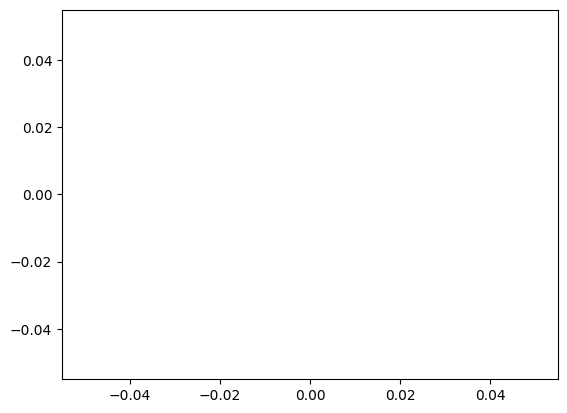

In [28]:
warning_x_sigmas = [r['sigma_x'] for r in warning_results]
warning_y_sigmas = [r['sigma_y'] for r in warning_results]

plt.plot(warning_x_sigmas, alpha=0.5)
plt.plot(warning_y_sigmas, alpha=0.5)
plt.show()


##### Plot overall results

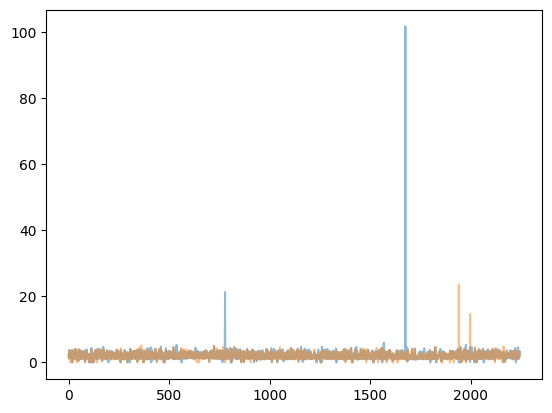

In [29]:
x_sigmas = [r['sigma_x'] for r in gaussian_fit_results]
y_sigmas = [r['sigma_y'] for r in gaussian_fit_results]

plt.plot(x_sigmas, alpha=0.5)
plt.plot(y_sigmas, alpha=0.5)
plt.show()

In [30]:
print("Max x_sigma:", np.max(x_sigmas), "at index:", np.argmax(x_sigmas))
print("Max y_sigma:", np.max(y_sigmas), "at index:", np.argmax(y_sigmas))


Max x_sigma: 101.77461909865038 at index: 1675
Max y_sigma: 23.65386035296003 at index: 1941


In [31]:
gaussian_fit_results[1625]

{'amplitude': np.float64(92.10220716476657),
 'xo': np.float64(20.6530393169031),
 'yo': np.float64(20.961674890451768),
 'sigma_x': np.float64(1.4079132257934084),
 'sigma_y': np.float64(1.9879083553628232),
 'offset': np.float64(185.09834145465612),
 'signal': np.float64(66.812917145923),
 'frame': 95,
 'particle': 17}

In [32]:
#display_particle(strong_tracks, test[98], particle_number=26, frame_number=98, radius=20)

#### For simplicity, just clip sigma estimations

In [33]:
raw_fit_df = pd.DataFrame(gaussian_fit_results)
print(raw_fit_df.shape)
raw_fit_df.head()

(2244, 9)


,amplitude,xo,yo,sigma_x,sigma_y,offset,signal,frame,particle
0,76.290929,20.589093,20.281557,2.316915,2.617696,186.042345,60.924699,0,5
1,98.096452,20.832730,19.076582,1.291481,2.106789,175.899978,69.894906,0,6
2,1105.400027,20.858360,20.230408,1.358609,1.180401,179.717238,643.880045,0,7
3,52.873112,20.831044,20.021897,3.275443,3.606285,179.153660,46.865153,0,8
4,205.254510,20.056462,20.752637,1.461409,1.036486,181.683453,116.396535,0,9


In [34]:
# pandas returns array ops in series, so I'm typing everything out
clip_low, clip_high = 0.01, 0.99

low_x_sigma_threshold = raw_fit_df['sigma_x'].quantile(clip_low)
high_x_sigma_threshold = raw_fit_df['sigma_x'].quantile(clip_high)
low_y_sigma_threshold = raw_fit_df['sigma_y'].quantile(clip_low)
high_y_sigma_threshold = raw_fit_df['sigma_y'].quantile(clip_high)


print(f"x_sigma cutoffs: ({low_x_sigma_threshold},{high_x_sigma_threshold}),    y_sigma cutoff : ({low_y_sigma_threshold}{high_y_sigma_threshold})")

fit_df = raw_fit_df.copy()
fit_df = fit_df[fit_df['sigma_x'] >= low_x_sigma_threshold]
fit_df = fit_df[fit_df['sigma_x'] <= high_x_sigma_threshold]
fit_df = fit_df[fit_df['sigma_y'] >= low_y_sigma_threshold]
fit_df = fit_df[fit_df['sigma_y'] <= high_y_sigma_threshold]

print(fit_df.shape)
fit_df.head()
pixel_kde = fit_pixel_noise_kde(test, strong_tracks, radius=20)


x_sigma cutoffs: (0.036421359209629654,4.420684517019667),    y_sigma cutoff : (0.0228648129269249734.2447695970825405)
(2161, 9)


100%|██████████| 132/132 [00:20<00:00,  6.45it/s]


##### Plot sigma estimations over signal

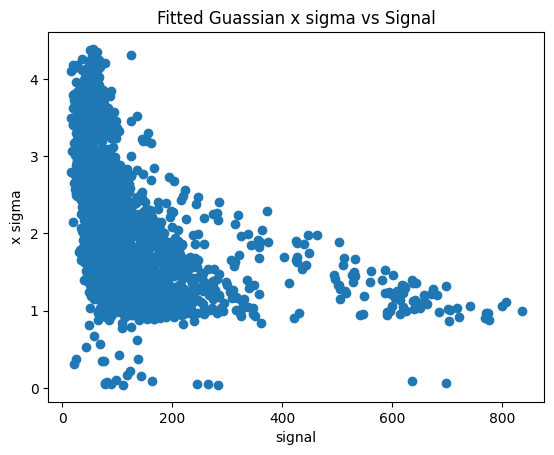

In [35]:
plt.scatter(fit_df['signal'], fit_df['sigma_x'])
plt.xlabel("signal")
plt.ylabel("x sigma")
plt.title("Fitted Guassian x sigma vs Signal")
plt.show()

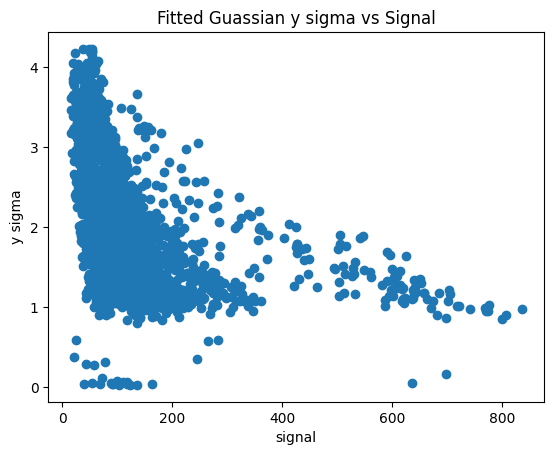

In [36]:
plt.scatter(fit_df['signal'], fit_df['sigma_y'])
plt.xlabel("signal")
plt.ylabel("y sigma")
plt.title("Fitted Guassian y sigma vs Signal")
plt.show()

#### Look at sigma change for individual particles

from before: Always present particles: [4, 5, 6, 7, 8, 9, 10, 12, 14, 17, 22, 25, 26, 27, 28, 29, 30, 31]

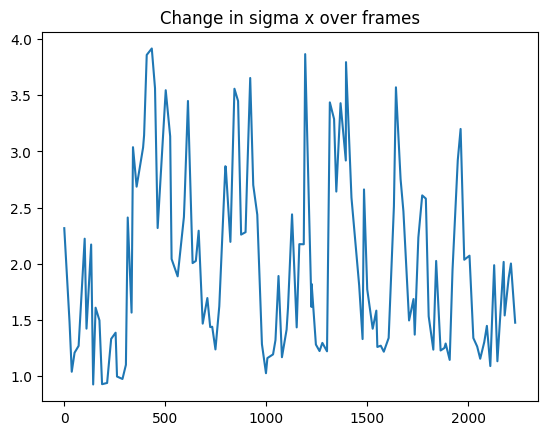

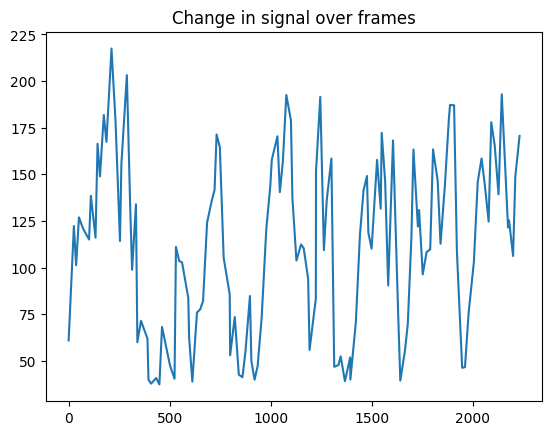

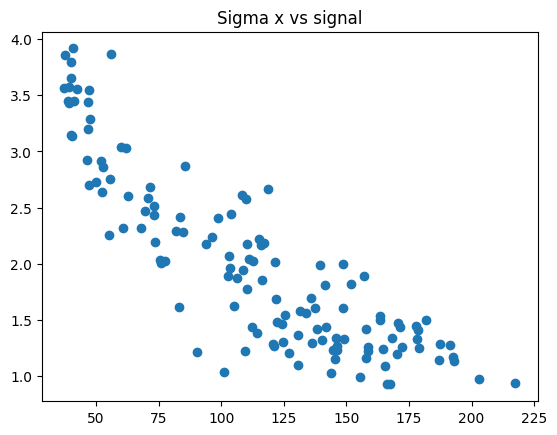

In [37]:
# particle 7 is the high signal particle, but it's signal still varies wildly and gets down to 200
fit_particle_num = 5

fit_particle = fit_df[fit_df['particle'] == fit_particle_num]
fit_particle.head()

plt.plot(fit_particle['sigma_x'])
plt.title("Change in sigma x over frames")
plt.show()

plt.plot(fit_particle['signal'])
plt.title("Change in signal over frames")
plt.show()

plt.scatter(fit_particle['signal'], fit_particle['sigma_x'])
plt.title("Sigma x vs signal")
plt.show()

### Turn this into a distribution

From all of this, it seems like a particle's signal is pretty jumpy.

So in the simulation, we're just going to sample from the signal distrbution prior, and then we'll have the particle's signal change randomly with a cap.

We can then sample from the signal vs sigma prior to get our guassian blur

**current method:**

For time, I'm just going to make bins of the data and sample a gaussian fit to the bin. This is probably not the best for this data and I shuold ask what sample function I should use.

In [38]:
from scipy.stats import gaussian_kde

def kde_signal_sample(fitted, num_samples=1, min_signal=20):
    kde = gaussian_kde(fitted["signal"])

    # Initialize a list to hold valid samples
    valid_samples = []

    # Keep drawing until we have enough valid samples
    while len(valid_samples) < num_samples:
        # Draw more than needed to reduce iterations (e.g., 2× oversample)
        new_samples = kde.resample(num_samples).flatten()

        # Keep only samples ≥ 20
        filtered = new_samples[new_samples >= 20]

        valid_samples.extend(filtered.tolist())

    # Slice to desired number and reshape
    final_signals = np.array(valid_samples[:num_samples]).flatten()

    if num_samples == 1:
        return final_signals[0]
    else:
        return final_signals


def kde_bin_sigma_sample(fitted, signal, sigma_min = 0.89):
    df = fitted.copy()

    bin_edges = np.arange(0, df['signal'].max()+50, 50)
    #print(bin_edges)
    df['signal_bin'] = pd.cut(df['signal'], bins=bin_edges)

    # Find bin index for the given signal value
    bin_index = np.digitize([signal], bin_edges)[0] - 1

    # Handle out-of-range cases
    if bin_index < 0 or bin_index >= len(bin_edges) - 1:
        raise ValueError("Signal value is outside the range of bins.")

    # Get bin range and corresponding data
    bin_range = pd.Interval(left=bin_edges[bin_index], right=bin_edges[bin_index+1], closed='right')
    #print(bin_range)
    bin_data = df[df['signal_bin'] == bin_range]['sigma_x']

    if len(bin_data) < 2:
        print(f"Not enough data in bin for signal {signal}. Found {len(bin_data)} points. {len(bin_data)}")
        raise ValueError(f"Not enough data in bin for signal {signal}. Found {len(bin_data)} points. {len(bin_data)}")

    # Fit KDE on x_sigma values in this bin
    kde = gaussian_kde(bin_data)
    sampled_x_sigma=kde.resample(1).flatten()[0]

    while sampled_x_sigma < sigma_min:
        sampled_x_sigma=kde.resample(1).flatten()[0]

    bin_data = df[df['signal_bin'] == bin_range]['sigma_y']

    if len(bin_data) < 2:
        print(f"Not enough data in bin for signal {signal}. Found {len(bin_data)} points. {len(bin_data)}")
        raise ValueError(f"Not enough data in bin for signal {signal}. Found {len(bin_data)} points. {len(bin_data)}")

    # Fit KDE on x_sigma values in this bin
    kde = gaussian_kde(bin_data)
    sampled_y_sigma=kde.resample(1).flatten()[0]

    while sampled_y_sigma < sigma_min:
        sampled_y_sigma=kde.resample(1).flatten()[0]

    return {"x_sigma" : sampled_x_sigma, "y_sigma" : sampled_y_sigma}

In [39]:
kde_bin_sigma_sample(fit_df, 799)

{'x_sigma': np.float64(1.1326152656049358),
 'y_sigma': np.float64(0.9994423880041663)}

In [40]:
fit_df['signal'].min()

15.641213016229429

In [41]:
kde_signal_sample(fit_df)

np.float64(104.57741440369888)

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

# Create simulation

**note:** positions array is in pixels!!!!!

Steps:
- assign radii from normal distribution
- assign uniform random positions
- use brownian motion equations to simulate positions
- add signal to each particle (make sure is less than 799)
- have signal do a clipped random walk (20, 799) with standard deviation 100


## Simulate Positions with brownian motion

#### helper functions from Inference layouts

In [42]:
def nano(num):
    return num * 10**(-9)

def stokes_einstein(r, t, T_Kelvin, eta):
    # Boltzmann's constant
    k_B = 1.38e-23

    # Calculate diffusion coefficient using Stokes-Einstein relation
    D = (k_B * T_Kelvin) / (6 * np.pi * eta * r)

    return D

def no_noise_simulation(positions, radii, num_frames, pixel_size, t=0.1, T_Kelvin=296.55, eta=9.2e-4):

    # generate diffusion coefficients
    Ds = stokes_einstein(radii, t, T_Kelvin, eta)
    # calculate sigmas
    variance = 2 * Ds * t
    sigmas = np.sqrt(variance)

    # do wiener step process
    for frame in range(1, num_frames):
        # from previous group:
        move = np.column_stack((np.random.normal(0, sigmas, num_particles),
                                     np.random.normal(0, sigmas, num_particles)))
        # divide meter movements by pixel size
        pixel_move = move / pixel_size

        # add pixel movements to position array
        positions[frame] = positions[frame - 1] + pixel_move

    return positions

#### set radii and simulate

In [43]:
num_particles = 10
radii = np.random.normal(nano(100), nano(20), num_particles)


# from test data
pixel_size = nano(314.3)
num_frames = 138
sim_res = (2048, 2048)
t = 0.1 #100 ms
T_Celsius = 23.4
T_Kelvin = T_Celsius + 273.15 #C to Kelvin
eta = 9.2e-4


# set initial positions by uniform pixels
positions = np.zeros((num_frames, num_particles, 2))
positions[0, :, 0] = np.random.uniform(0, sim_res[0], num_particles)
positions[0, :, 1] = np.random.uniform(0, sim_res[1], num_particles)

# generate simulated positions
positions = no_noise_simulation(positions, radii, num_frames, pixel_size, t, T_Kelvin, eta)
positions.shape

(138, 10, 2)

#### Simulate signal (unrelated to particle size)

In [44]:
signal_walk_mean = 0
signal_walk_sigma = 50
min_signal = 70
max_signal = 799


signals = np.zeros((num_frames, num_particles, 1))

# assign values from kde signal sampler
starting_signals = kde_signal_sample(fit_df, num_samples=num_particles, min_signal=min_signal)
signals[0,:,0] = starting_signals

# do random walk for signal simulation
for frame in range(1, num_frames):
    # signal walk
    signal_change = np.column_stack((np.random.normal(signal_walk_mean, signal_walk_sigma, num_particles)))

    # add signal movements
    signals[frame,:,0] = signals[frame - 1,:,0] + signal_change

    # clip to range
    signals[frame,:,0] = np.clip(signals[frame,:,0], min_signal, max_signal)

#### Append signals as third position

In [45]:
positions_with_signals = np.concatenate((positions, signals), axis=2)

$$ $$

## Generate Images

In [46]:
window_multiplier = 5
particle_mask_noise_mu = 0
particle_mask_noise_sigma = 2

H, W = sim_res
Xg, Yg = np.meshgrid(np.arange(W), np.arange(H))     # reuse for every frame

tuning_mode   = True    # <-- set False after grid‑search
use_pixel_kde = True    # <-- keep True for final render

_patch_grid_cache = {}  # cache local meshgrids by (width,height) key

def add_particle_mask(frame,
                      particle_x,
                      particle_y,
                      signal,
                      sigma_mul: float = 1.0):
    #   PSF widths
    sig       = kde_bin_sigma_sample(fit_df, signal)
    sigma_x   = sig['x_sigma'] * sigma_mul
    sigma_y   = sig['y_sigma'] * sigma_mul

    #   window bounds
    size_x    = int(window_multiplier * sigma_x)
    size_y    = int(window_multiplier * sigma_y)
    x_min     = max(0, int(particle_x - size_x))
    x_max     = min(frame.shape[1], int(particle_x + size_x + 1))
    y_min     = max(0, int(particle_y - size_y))
    y_max     = min(frame.shape[0], int(particle_y + size_y + 1))
    if x_min >= x_max or y_min >= y_max:
        return                      # patch lies outside FOV

    #   local meshgrid
    key = (x_max - x_min, y_max - y_min)
    if key not in _patch_grid_cache:
        xs = np.arange(key[0]); ys = np.arange(key[1])
        _patch_grid_cache[key] = np.meshgrid(xs, ys)
    Xloc, Yloc = _patch_grid_cache[key]
    X = Xloc + x_min
    Y = Yloc + y_min

    #  ideal Gaussian PSF
    g = signal * np.exp(
        -(((X - particle_x)**2) / (2 * sigma_x**2) +
          ((Y - particle_y)**2) / (2 * sigma_y**2))
    ).astype(np.float32)

    #  pixel‑level noise (skip during tuning)
    if (not tuning_mode) and use_pixel_kde and (pixel_kde is not None):
        noise = pixel_kde.resample(g.size).reshape(g.shape)
    elif (not tuning_mode):
        noise = np.random.normal(particle_mask_noise_mu,
                                 particle_mask_noise_sigma,
                                 size=g.shape)
    else:
        noise = 0.0                # fast branch for grid search

    frame[y_min:y_max, x_min:x_max] += (g + noise).astype(np.uint16)




In [47]:
sim_output_folder = "test_simulation"
os.makedirs(sim_output_folder, exist_ok=True)

# go through and render all frames
# put them in a folder as individual tiff files
for frame_num in tqdm(range(num_frames)):
    # generate fitted background noise
    background = np.random.normal(loc=fitted_noise_mu, scale=fitted_noise_sigma, size=sim_res)
    # clip noise for safety and convert to uint16
    frame = np.clip(background, 0, 65535).astype(np.uint16)


    # retrieve positions and signals in the frame
    frame_particles = positions_with_signals[frame_num]

    # render each particle
    for particle in frame_particles:
        particle_mask = add_particle_mask(frame, particle_x = particle[0], particle_y = particle[1], signal = particle[2])

    # save frame
    tifffile.imwrite(f"{sim_output_folder}/frame_{frame_num:04d}.tif", frame)



100%|██████████| 138/138 [00:32<00:00,  4.28it/s]


In [48]:
noise_amp       = 1.0             # background noise scale
sigma_mul       = 1.0             # PSF width multiplier
background_grad = (0.0, 0.0)      # (grad_x, grad_y)


def simulate_frame(frame_num, noise_amp, sigma_mul, background_grad):
    #  background
    bg = np.random.normal(loc=fitted_noise_mu,
                          scale=fitted_noise_sigma,
                          size=sim_res)
    frame = (bg * noise_amp).astype(np.float32)

    #   illumination gradient (reuse Xg,Yg)
    gx, gy = background_grad
    frame += gx * Xg + gy * Yg

    #   clip & convert
    frame = np.clip(frame, 0, 65535).astype(np.uint16)

    #   stamp all particles
    for px, py, signal in positions_with_signals[frame_num]:
        add_particle_mask(frame, px, py, signal, sigma_mul)

    return frame


In [49]:
real_frames = [np.asarray(f).astype(float) for f in test]  # or however you opened them
real_frames = real_frames[:10]                             # tune on first 10
frame_nums  = list(range(len(real_frames)))


import itertools


def tune_simulator(real_frames, frame_nums,
                   noise_vals, sigma_vals, grad_x_vals, grad_y_vals):
    best_rms = float('inf')
    best_params = None
    for na, sm, gx, gy in itertools.product(
            noise_vals, sigma_vals, grad_x_vals, grad_y_vals):
        total = 0
        for i, real in zip(frame_nums, real_frames):
            sim = simulate_frame(i, na, sm, (gx, gy))
            total += np.sqrt(np.mean((sim.astype(float) - real.astype(float))**2))
        avg = total / len(real_frames)
        if avg < best_rms:
            best_rms, best_params = avg, {
                'noise_amp': na,
                'sigma_mul': sm,
                'background_grad': (gx, gy)
            }
    return best_params, best_rms

# Example call on first 10 real frames
best_params, best_rms = tune_simulator(
    real_frames=real_frames,    # your actual list
    frame_nums=frame_nums,      # the matching indices
    noise_vals=[0.5, 1.0, 1.5],
    sigma_vals=[0.8, 1.0, 1.2],
    grad_x_vals=[-0.01, 0.0, 0.01],
    grad_y_vals=[-0.01, 0.0, 0.01]
)
print("Best params:", best_params, "RMS:", best_rms)

Best params: {'noise_amp': 1.0, 'sigma_mul': 0.8, 'background_grad': (0.01, -0.01)} RMS: 27.151052549381166


In [50]:

sim_output_folder = "test_simulation"
os.makedirs(sim_output_folder, exist_ok=True)

tuning_mode = False          # turn FULL pixel noise back on
print("Rendering final stack with pixel‑level KDE noise …")

for frame_num in tqdm(range(num_frames), desc="render"):
    frame = simulate_frame(
        frame_num,
        best_params['noise_amp'],
        best_params['sigma_mul'],
        best_params['background_grad']
    )
    tifffile.imwrite(
        f"{sim_output_folder}/frame_{frame_num:04d}.tif",
        frame
    )


Rendering final stack with pixel‑level KDE noise …


render: 100%|██████████| 138/138 [01:38<00:00,  1.40it/s]


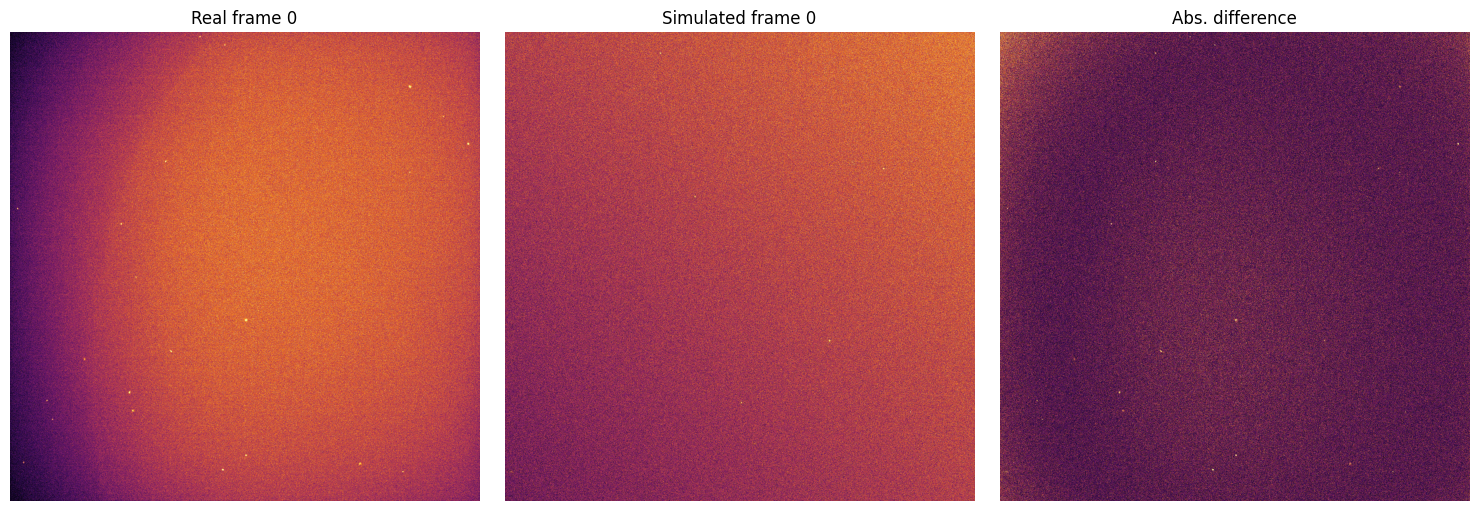

In [51]:
import matplotlib.pyplot as plt
import numpy as np

def _norm(img, p_lo=0.5, p_hi=99.5):
    "Return image scaled to 0–1 by chosen percentiles."
    lo, hi = np.percentile(img, [p_lo, p_hi])
    return np.clip((img - lo) / (hi - lo), 0, 1)

idx = 0                                                # frame to inspect
real_img = real_frames[idx]
sim_img  = simulate_frame(idx,
                          best_params['noise_amp'],
                          best_params['sigma_mul'],
                          best_params['background_grad']).astype(float)

# scale each independently so faint structure is visible
real_vis = _norm(real_img)
sim_vis  = _norm(sim_img)

# diff scaled to same range as sim for intuitive brightness
diff_vis = _norm(np.abs(real_img - sim_img))

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["Real frame {}".format(idx),
          "Simulated frame {}".format(idx),
          "Abs. difference"]

for ax, data, ttl in zip(axes, [real_vis, sim_vis, diff_vis], titles):
    ax.imshow(data, cmap='inferno')
    ax.set_title(ttl); ax.axis('off')

plt.tight_layout(); plt.show()


In [ ]:
#  Discrete grid search: what the tuning output & sanity‑check image tell us
#
#  Optimisation method: a discrete brute‑force grid search (81 total combos) over
#   three global knobs:
#       1) noise_amp        – scales the background grain,
#       2) sigma_mul        – multiplies every PSF width,
#       3) background_grad  – (gx, gy) linear brightness ramp.
#
#   minimise pixel‑wise RMS error between each simulated frame and the first
#   ten real SEM frames.  The winning combo was:
#       noise_amp       = 1.0      # background already at correct amplitude
#       sigma_mul       = 0.8      # PSFs needed to be ~20 % sharper
#       background_grad = (0.01, -0.01)  # mild diagonal illumination slope
#   The resulting RMS error was 27 DN which is low compared to the background level
#
#  Visual sanity check (three‑panel figure):
#       left   : real frame 0
#       middle : simulated frame 0 (tuned params)
#       right  : absolute pixel difference (log‑scaled)
#
#   Interpretation:
# Original SEM image with diagonal gradient & fine grain.    # Baseline texture.
# Synthetic with tuned params; grain & gradient align well.  # Knobs succeeded.
# Mostly dark; bright at particle centres & faint diagonal.  # Residuals near noise floor, minimal bias.
#
# Conclusion: The discrete grid search produced parameters that replicate both global
# illumination and local PSF structure closely enough for reliable downstream tracking
# and Bayesian inference.


## Export information

In [52]:
# save through pandas using datafram
frame_nums = np.repeat(np.arange(num_frames), num_particles)
# np.tile repeats A the given number of times
particle_nums = np.tile(np.arange(num_particles), num_frames)

# Flatten positions array
flat_positions = positions_with_signals.reshape(-1, 3)

# Create DataFrame
sim_ground_df = pd.DataFrame({
    'frame': frame_nums,
    'particle': particle_nums,
    'pixel_x': flat_positions[:, 0],
    'pixel_y': flat_positions[:, 1],
    'signal': flat_positions[:, 2]
})

sim_ground_df['x'] = sim_ground_df['pixel_x'] * pixel_size
sim_ground_df['y'] = sim_ground_df['pixel_y'] * pixel_size

# Add radius by mapping particle index
radius_per_particle = radii[particle_nums]
sim_ground_df['radius'] = radius_per_particle

# Save to Excel
sim_ground_df.to_excel('simulation_ground_truths.xlsx', index=False)

In [53]:
sim_ground_df.head()

,frame,particle,pixel_x,pixel_y,signal,x,y,radius
0,0,0,1512.778410,571.399901,25.249492,0.000475,0.000180,1.125111e-07
1,0,1,1766.001083,1658.899319,89.326033,0.000555,0.000521,1.010596e-07
2,0,2,827.507927,721.002346,84.848995,0.000260,0.000227,9.130759e-08
3,0,3,1392.441285,182.311479,26.836322,0.000438,0.000057,1.423178e-07
4,0,4,1088.017125,1797.434333,34.872931,0.000342,0.000565,9.443079e-08


In [54]:
positions_with_signals[1]

array([[1512.46225108,  570.69222459,   70.        ],
       [1763.49500496, 1659.86201825,  121.72100664],
       [ 826.98260182,  721.37225694,  113.45549629],
       [1391.18987589,  184.73971357,   70.        ],
       [1089.7061349 , 1793.47848175,   70.        ],
       [ 672.37173498,   96.57476804,  203.77862833],
       [1032.78997373, 1623.16173921,  164.73863718],
       [1646.93268687,  598.84314468,  131.66584244],
       [  27.74168822, 1922.87940087,   81.09597219],
       [1414.98762775, 1352.46557804,   70.        ]])

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$


$$ $$

$$ $$

$$ $$

$$ $$


$$ $$

# Implement TrackPy on Simulation

## Read simulation with pims

In [55]:
sim = pims.open(f"{sim_output_folder}/*.tif")

## Gamma adjust simulation

In [56]:
sim_gamma_folder = "sim_gamma"
os.makedirs(sim_gamma_folder, exist_ok=True)
for i, frame in enumerate(sim):
    processed = adjust_frame(frame, gamma=2, clip_quantile=0.9999)
    #print(np.max(frame), np.max(processed), processed.dtype)
    #print(((processed != 0) & (processed != 1)).sum())
    #percentiles(processed)
    tifffile.imwrite(f"{sim_gamma_folder}/frame_{i:04d}.tif", processed)

In [57]:
sim_adjusted = pims.open(f"{sim_gamma_folder}/*.tif")

## Apply TrackPy to the simulation data

(11, 9)


array([[<Axes: title={'center': 'x'}>, <Axes: title={'center': 'y'}>]],
      dtype=object)

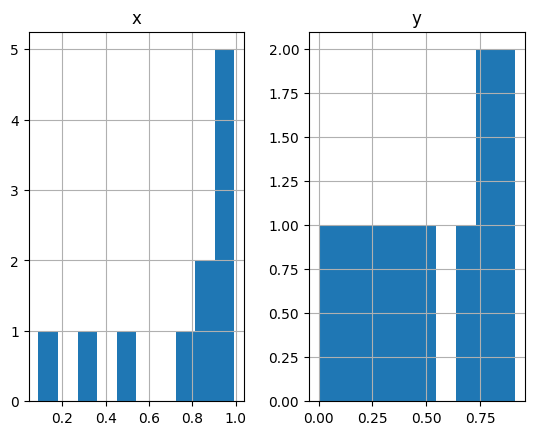

In [58]:
features = tp.locate(sim[0], minmass=1300, diameter = 21)

print(features.shape)
tp.subpx_bias(features)

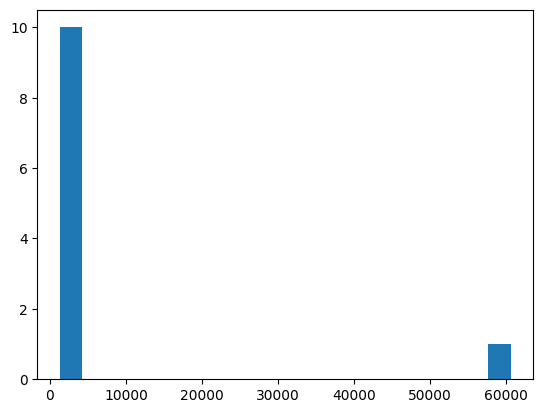

In [59]:
plt.hist(features['mass'], bins=20)
plt.show()

In [60]:
video_features = tp.batch(sim, diameter=21, minmass=1300);

Frame 137: 13 features


In [61]:
raw_tracks = tp.link(video_features, search_range=20, memory=5)
tracks = tp.filter_stubs(raw_tracks, 20)
print('Before:', raw_tracks['particle'].nunique())
print('After:', tracks['particle'].nunique())

Frame 137: 13 trajectories present.
Before: 685
After: 11


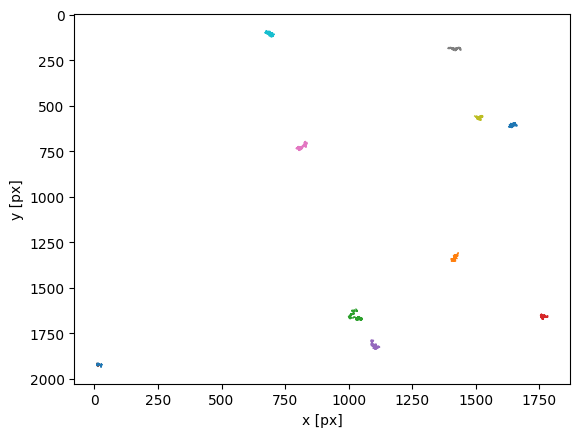

<Axes: xlabel='x [px]', ylabel='y [px]'>

In [62]:
tp.plot_traj(tracks)

In [63]:
export_annotated_video(tracks, sim_adjusted, "normal_sim_adjusted_annotated.mp4", numbers=True, fps=3)

Saved to normal_sim_adjusted_annotated.mp4


In [64]:
# get particle nums with detection at every frame:
num_frames = len(tracks['frame'].unique())

full_particles = []
for particle in tracks['particle'].unique():
    particle_df = tracks[tracks["particle"] == particle]

    if len(particle_df) == num_frames:
        full_particles.append(int(particle))

print("Unique particles:", tracks["particle"].unique())
print()
print("Always present particles:", full_particles)

Unique particles: [  0   1   2   3   5   7   9  12  13  15 403]

Always present particles: []


$$ $$

$$ $$

$$ $$

## Apply MCMC Estimation on simulation TrackPy output

**note:** looking at gamma adjusted video with current simulation settings, I know that all the filtered tracks are correct. So I'm going to use all of them

#### Load Ground Truth Data and Set Sim Settings

In [65]:
ground = pd.read_excel("simulation_ground_truths.xlsx")

credible_percentage = 0.95

# sim settings
t =  0.1
T_Kelvin = 296.55
eta = 9.2e-4
k_B = 1.38e-23
pixel_size = nano(314.3)

C = (k_B * T_Kelvin * t) / (3 * np.pi * eta)

#### Convert TrackPy Locations


In [66]:
tp_converted = tracks.copy()
tp_converted['x'] = tp_converted['x'] * pixel_size
tp_converted['y'] = tp_converted['y'] * pixel_size

$$ $$

### Single Particle Demo

#### Get Track and Ground Info

In [67]:
# get first frame with all tracks:
full_frame = 0
while len(tp_converted[tp_converted['frame'] == full_frame]) != num_particles:
    full_frame += 1

print(f"First full frame: {full_frame}")

First full frame: 1


In [68]:
tp_particle_num = 1

tp_track = tp_converted[tp_converted['particle'] == tp_particle_num]

tp_track_full = tp_track[tp_track['frame'] == full_frame]
tp_x = tp_track_full['x'].item()
tp_y = tp_track_full['y'].item()

gnd_frame_full = ground[ground['frame'] == full_frame]

# determine ground truth num based on first frame
distances = np.sqrt((gnd_frame_full['x'] - tp_x)**2 + (gnd_frame_full['y'] - tp_y)**2)
closest_ind = np.argmin(distances)
gnd_num = gnd_frame_full.iloc[closest_ind]['particle']

# get ground truth radius:
true_radius = gnd_frame_full[gnd_frame_full['particle'] == gnd_num]['radius'].item()

print("Minimum distance:", np.min(distances))

Minimum distance: 3.4575291397836557e-06


#### Determine estimation errors

In [69]:
gnd_track = ground[ground['particle'] == gnd_num]

frames_present = tp_track["frame"]
gnd_present = gnd_track[gnd_track['frame'].isin(frames_present)]

x_errors = tp_track['x'].values - gnd_present['x'].values
y_errors = tp_track['y'].values - gnd_present['y'].values

errors = np.concatenate((x_errors, y_errors))

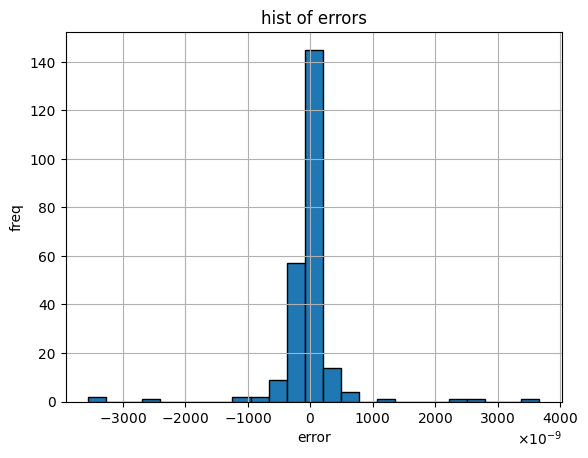

In [70]:
plt.hist(errors, bins=25, edgecolor='black')
plt.title("hist of errors")
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("error")
plt.ylabel("freq")
plt.grid(True)
plt.show()

In [71]:
from scipy.stats import norm

mu_error, sigma_error = norm.fit(errors)
print(mu_error, sigma_error)

-2.9225577142128036e-08 5.424256554244234e-07


#### Run MCMC model

Output()

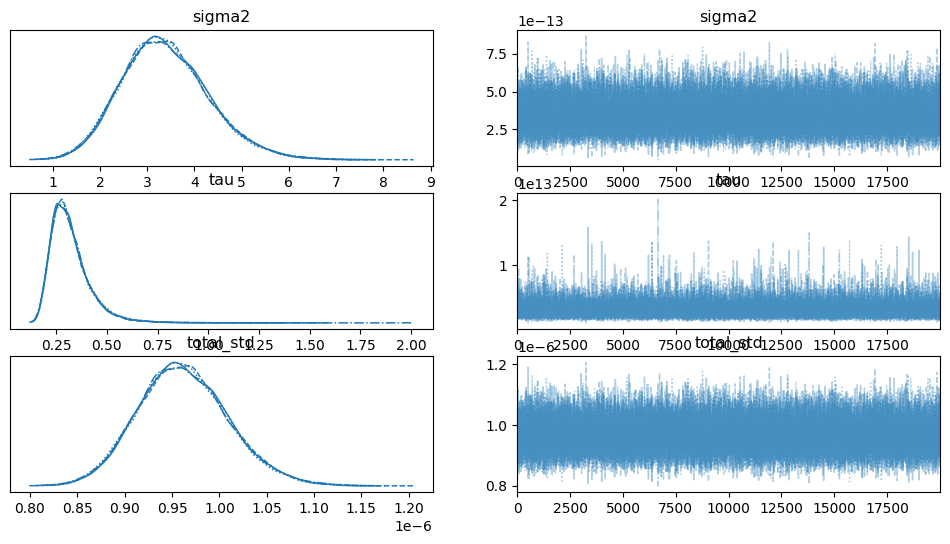

In [72]:
# Extract frame and position arrays
frames = tp_track['frame'].to_numpy()
x_pos = tp_track['x'].to_numpy()
y_pos = tp_track['y'].to_numpy()

# Identify which rows are sequential in frame
frame_diff = np.diff(frames)
sequential_mask = frame_diff == 1  # True where frames are consecutive

# Compute position diffs
x_diff = np.diff(x_pos)
y_diff = np.diff(y_pos)

# Only keep diffs for sequential frame steps
x_dist = x_diff[sequential_mask]
y_dist = y_diff[sequential_mask]

dists = np.concatenate((x_dist, y_dist))

sigma_e2 = sigma_error**2

# PyMC model
with pm.Model() as model:
    # Prior for process variance sigma^2 (can adjust based on domain knowledge)
    sigma2 = pm.HalfCauchy("sigma2", beta=2)

    tau = pm.Deterministic("tau", 1 / sigma2)

    # Total standard deviation of observed deltas
    total_std = pm.Deterministic("total_std", pm.math.sqrt(sigma2 + 2 * sigma_e2))

    # Likelihood
    obs = pm.Normal("obs", mu=0, sigma=total_std, observed=dists)

    # Run MCMC with NUTS
    trace = pm.sample(draws=20000, tune=10000, chains=4, target_accept=0.9, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["tau"])

# Plot trace
az.plot_trace(trace)
plt.show()

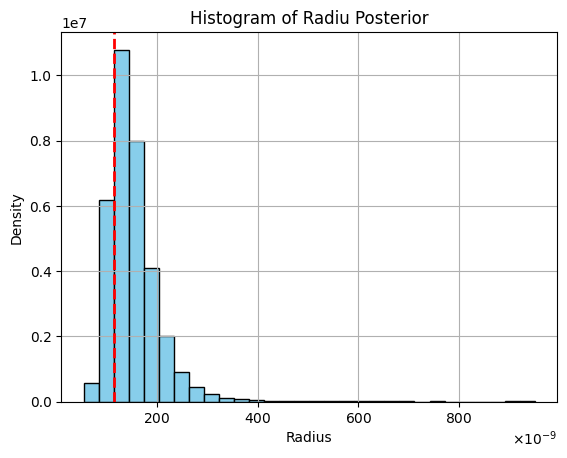

In [73]:
# Step 1: Extract samples of 'tau' from the trace
tau_samples = trace.posterior["tau"].values.flatten()  # shape: (n_samples * n_chains,)

# multiply by C
rad_samples = tau_samples * C

# make histogram
plt.hist(rad_samples, bins=30, density=True, color='skyblue', edgecolor='black')
plt.axvline(x=true_radius, color='red', linestyle='--', linewidth=2)
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("Radius")
plt.ylabel("Density")
plt.title("Histogram of Radiu Posterior")
plt.grid(True)
plt.show()

## Same thing, but assume error variance is 0

Output()

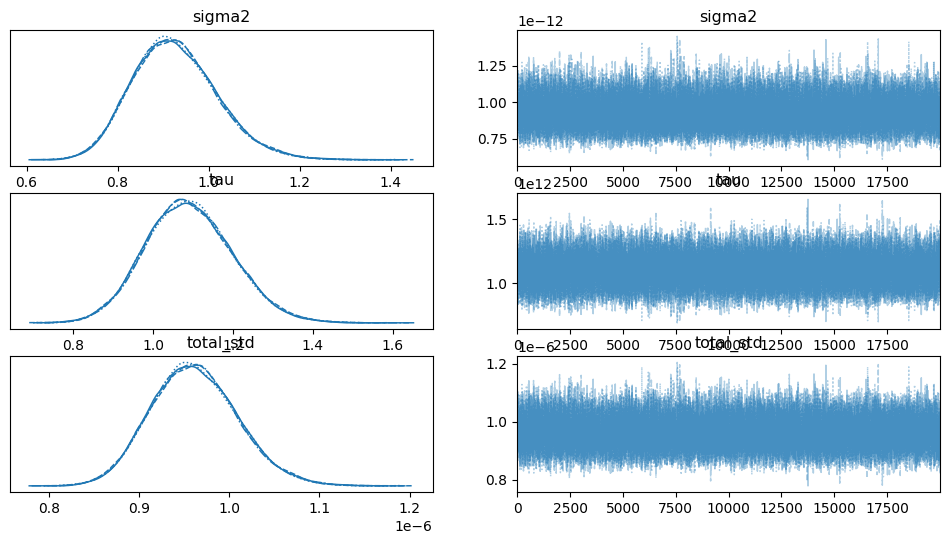

In [74]:
# Extract frame and position arrays
frames = tp_track['frame'].to_numpy()
x_pos = tp_track['x'].to_numpy()
y_pos = tp_track['y'].to_numpy()

# Identify which rows are sequential in frame
frame_diff = np.diff(frames)
sequential_mask = frame_diff == 1  # True where frames are consecutive

# Compute position diffs
x_diff = np.diff(x_pos)
y_diff = np.diff(y_pos)

# Only keep diffs for sequential frame steps
x_dist = x_diff[sequential_mask]
y_dist = y_diff[sequential_mask]
dists = np.concatenate((x_dist, y_dist))

sigma_e2 = 0

# PyMC model
with pm.Model() as model:
    # Prior for process variance sigma^2 (can adjust based on domain knowledge)
    sigma2 = pm.HalfCauchy("sigma2", beta=2)

    tau = pm.Deterministic("tau", 1 / sigma2)

    # Total standard deviation of observed deltas
    total_std = pm.Deterministic("total_std", pm.math.sqrt(sigma2 + 2 * sigma_e2))

    # Likelihood
    obs = pm.Normal("obs", mu=0, sigma=total_std, observed=dists)

    # Run MCMC with NUTS
    trace = pm.sample(draws=20000, tune=10000, chains=4, target_accept=0.9, return_inferencedata=True)

# Posterior summary
az.summary(trace, var_names=["tau"])

# Plot trace
az.plot_trace(trace)
plt.show()

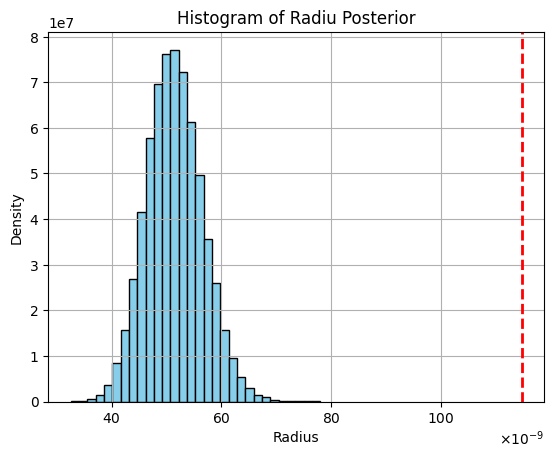

In [75]:
# Step 1: Extract samples of 'tau' from the trace
tau_samples = trace.posterior["tau"].values.flatten()  # shape: (n_samples * n_chains,)

# multiply by C
rad_samples = tau_samples * C

# make histogram
plt.hist(rad_samples, bins=30, density=True, color='skyblue', edgecolor='black')
plt.axvline(x=true_radius, color='red', linestyle='--', linewidth=2)
plt.gca().xaxis.set_major_formatter(nano_formatter)
plt.xlabel("Radius")
plt.ylabel("Density")
plt.title("Histogram of Radiu Posterior")
plt.grid(True)
plt.show()

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

$$ $$

## Run MCMC demo for all detected particles

#### Helper Functions

In [76]:
def get_ground_info(tp_track, ground, full_frame):
    tp_track_full = tp_track[tp_track['frame'] == full_frame]
    tp_x = tp_track_full['x'].item()
    tp_y = tp_track_full['y'].item()

    gnd_frame_full = ground[ground['frame'] == full_frame]

    # determine ground truth num based on first frame
    distances = np.sqrt((gnd_frame_full['x'] - tp_x)**2 + (gnd_frame_full['y'] - tp_y)**2)
    closest_ind = np.argmin(distances)
    gnd_num = gnd_frame_full.iloc[closest_ind]['particle']

    # get ground truth radius:
    true_radius = gnd_frame_full[gnd_frame_full['particle'] == gnd_num]['radius'].item()

    print("Minimum distance:", np.min(distances))

    return [gnd_num, true_radius]

def get_error_info(tp_track, ground, gnd_num):
    gnd_track = ground[ground['particle'] == gnd_num]

    frames_present = tp_track["frame"]
    gnd_present = gnd_track[gnd_track['frame'].isin(frames_present)]

    x_errors = tp_track['x'].values - gnd_present['x'].values
    y_errors = tp_track['y'].values - gnd_present['y'].values

    errors = np.concatenate((x_errors, y_errors))




    plt.hist(errors, bins=25, edgecolor='black')
    plt.title("hist of errors")
    plt.gca().xaxis.set_major_formatter(nano_formatter)
    plt.xlabel("error")
    plt.ylabel("freq")
    plt.grid(True)
    plt.show()


    mu_error, sigma_error = norm.fit(errors)

    return[mu_error, sigma_error]

def run_MCMC_with_error(tp_track, sigma_e2, true_radius, C, show_summary=True):
    # Extract frame and position arrays
    frames = tp_track['frame'].to_numpy()
    x_pos = tp_track['x'].to_numpy()
    y_pos = tp_track['y'].to_numpy()

    # Identify which rows are sequential in frame
    frame_diff = np.diff(frames)
    sequential_mask = frame_diff == 1  # True where frames are consecutive

    # Compute position diffs
    x_diff = np.diff(x_pos)
    y_diff = np.diff(y_pos)

    # Only keep diffs for sequential frame steps
    x_dist = x_diff[sequential_mask]
    y_dist = y_diff[sequential_mask]
    dists = np.concatenate((x_dist, y_dist))

    sigma_e2 = 0

    # PyMC model
    with pm.Model() as model:
        # Prior for process variance sigma^2 (can adjust based on domain knowledge)
        sigma2 = pm.HalfCauchy("sigma2", beta=2)

        tau = pm.Deterministic("tau", 1 / sigma2)

        # Total standard deviation of observed deltas
        total_std = pm.Deterministic("total_std", pm.math.sqrt(sigma2 + 2 * sigma_e2))

        # Likelihood
        obs = pm.Normal("obs", mu=0, sigma=total_std, observed=dists)

        # Run MCMC with NUTS
        trace = pm.sample(draws=20000, tune=10000, chains=4, target_accept=0.9, return_inferencedata=True, nuts_sampler="numpyro", progressbar=False)

    # Posterior summary
    if show_summary:
        az.summary(trace, var_names=["tau"])

        # Plot trace
        az.plot_trace(trace)
        plt.show()


    # Step 1: Extract samples of 'tau' from the trace
    tau_samples = trace.posterior["tau"].values.flatten()  # shape: (n_samples * n_chains,)

    # multiply by C
    rad_samples = tau_samples * C

    # make histogram
    plt.hist(rad_samples, bins=30, density=True, color='skyblue', edgecolor='black')
    plt.axvline(x=true_radius, color='red', linestyle='--', linewidth=2)
    plt.gca().xaxis.set_major_formatter(nano_formatter)
    plt.xlabel("Radius")
    plt.ylabel("Density")
    plt.title("Histogram of Radiu Posterior")
    plt.grid(True)
    plt.show()


#### Running everything:

Particle 0, detections : 136
Minimum distance: 4.203632219714587e-07


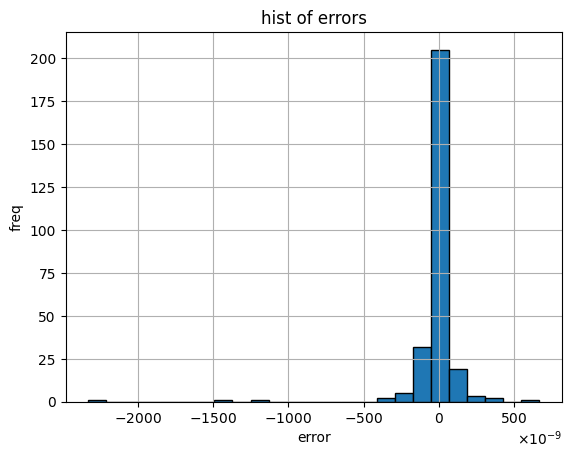

mu_error: -1.8428610518914377e-08,      sigma_error : 2.0015756748818217e-07


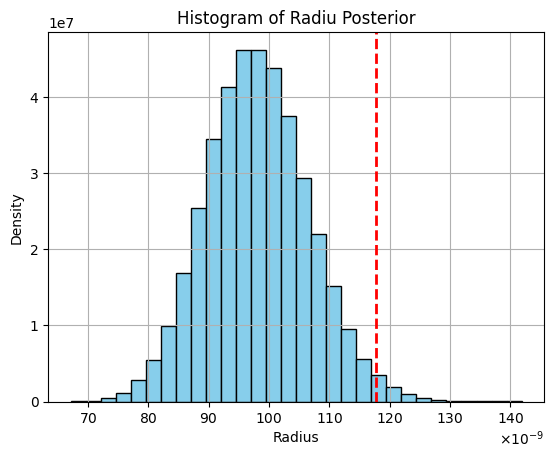

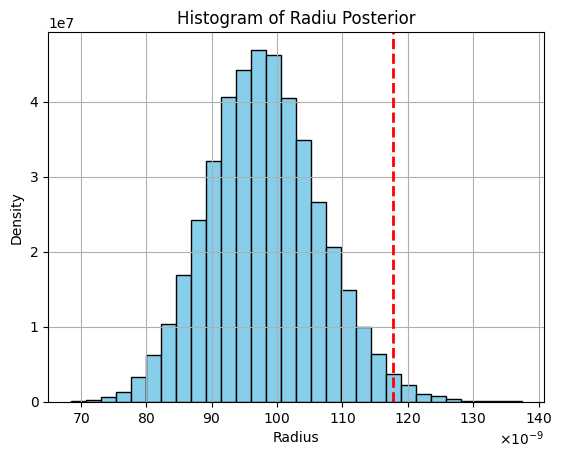

Particle 1, detections : 120
Minimum distance: 3.4575291397836557e-06


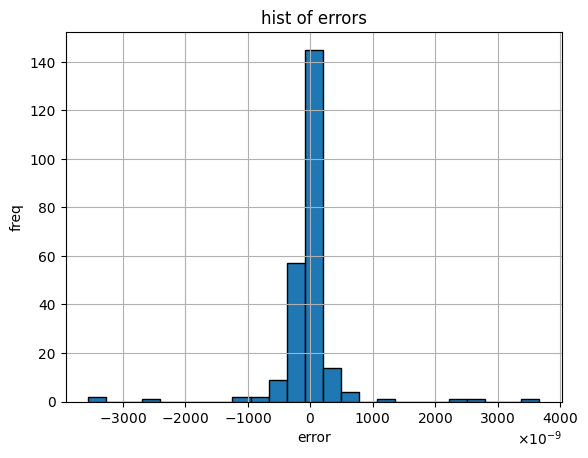

mu_error: -2.9225577142128036e-08,      sigma_error : 5.424256554244234e-07


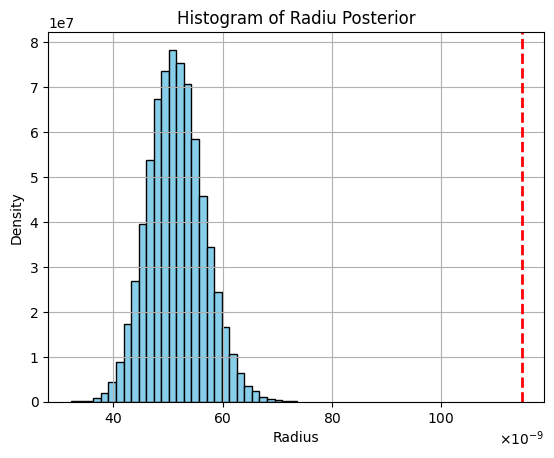

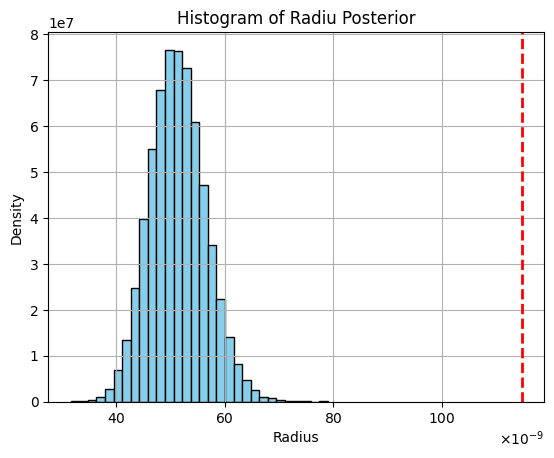

Particle 2, detections : 137
Minimum distance: 3.251508953523523e-08


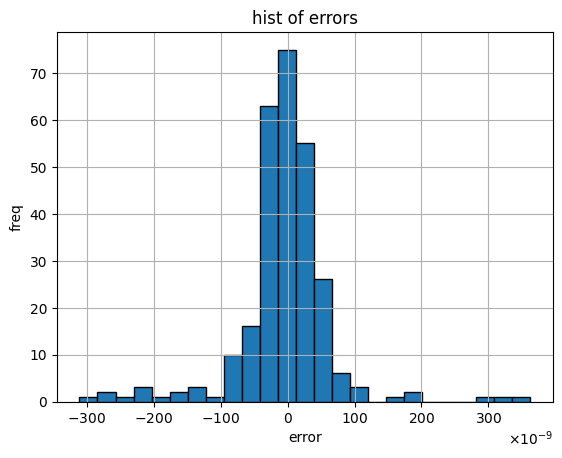

mu_error: -4.285947332599117e-09,      sigma_error : 6.898079523007904e-08


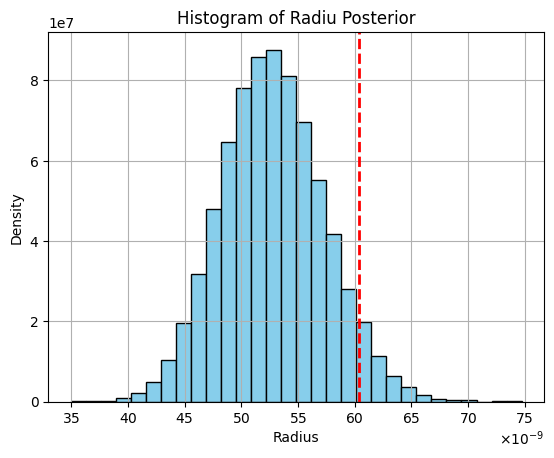

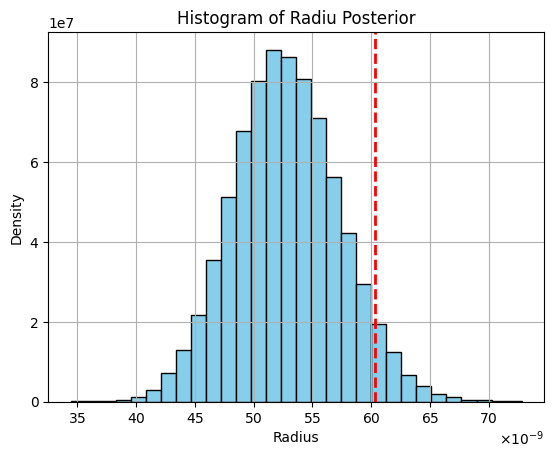

Particle 3, detections : 134
Minimum distance: 1.2221339583721498e-07


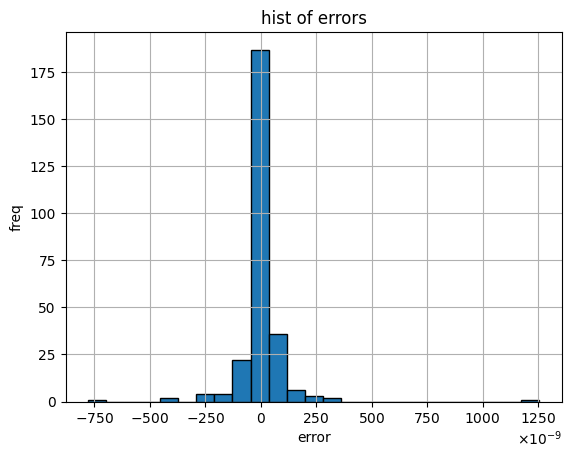

mu_error: 1.1682011711383554e-10,      sigma_error : 1.1788613667187113e-07


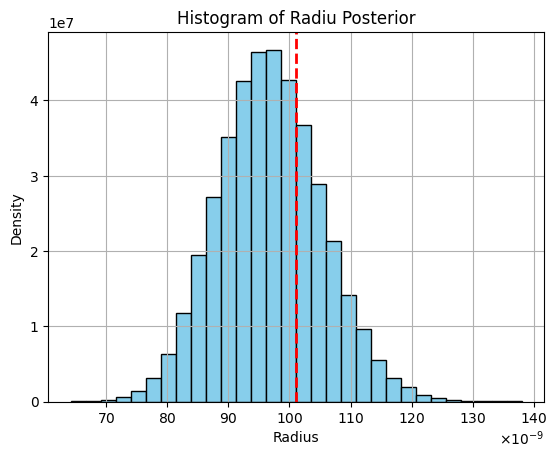

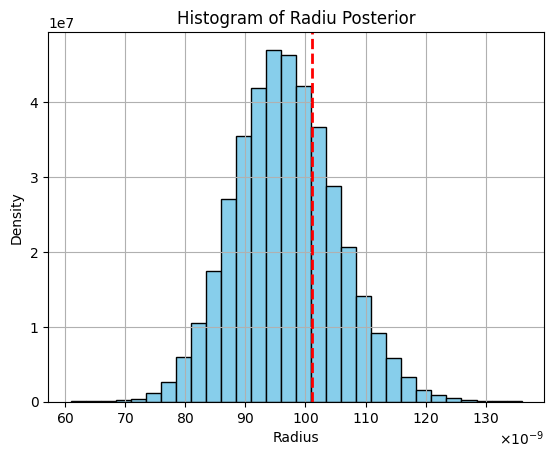

Particle 5, detections : 132
Minimum distance: 1.6883299217106517e-07


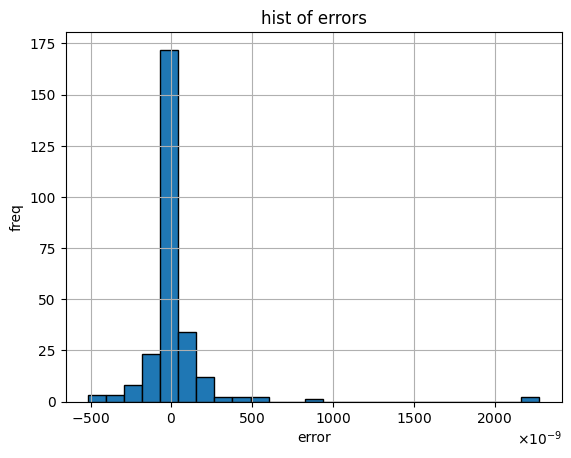

mu_error: 1.7171306029173813e-08,      sigma_error : 2.3642825115843512e-07


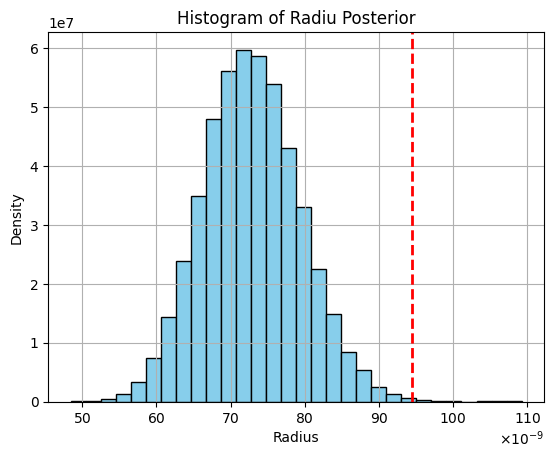

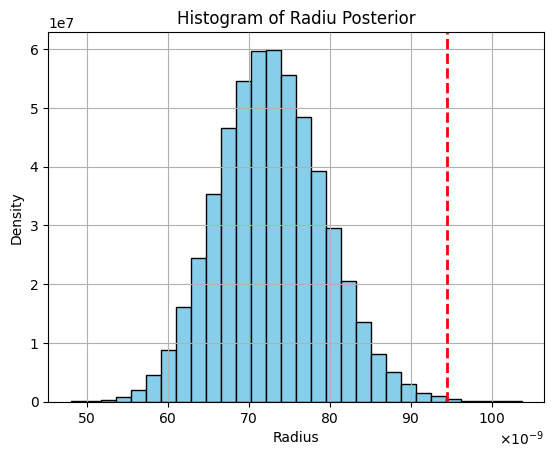

Particle 7, detections : 52
Minimum distance: 9.739925917891523e-08


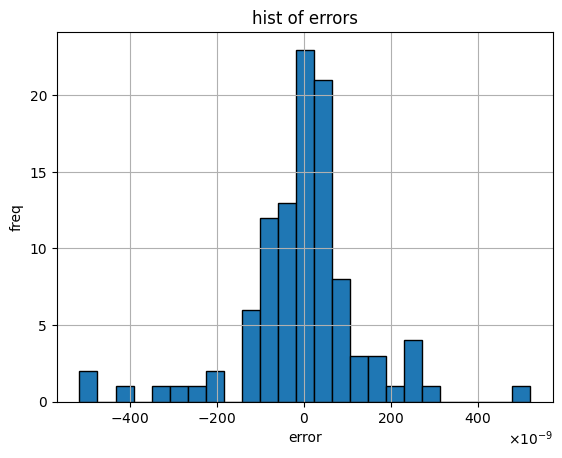

mu_error: -4.025911174287449e-09,      sigma_error : 1.3994098590813975e-07


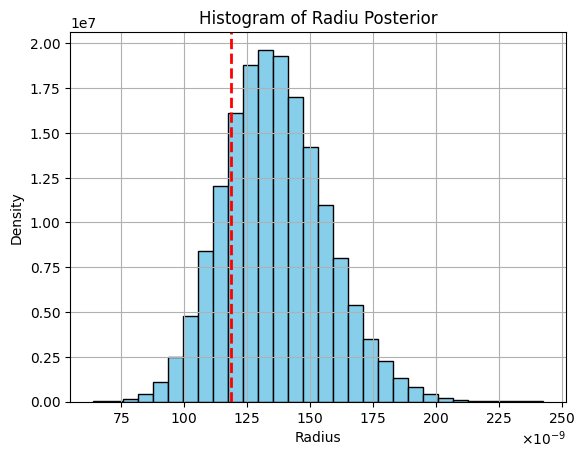

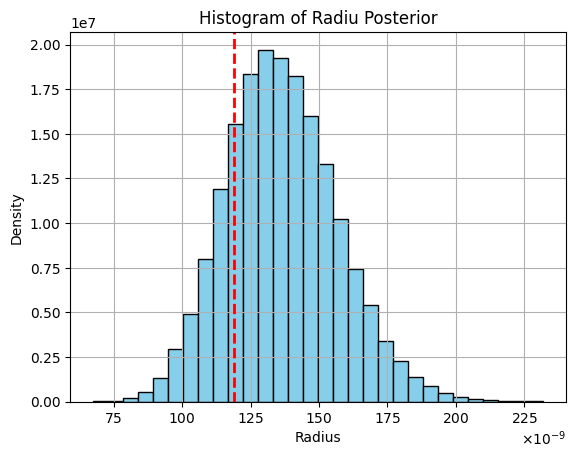

Particle 9, detections : 132
Minimum distance: 8.127084970207708e-08


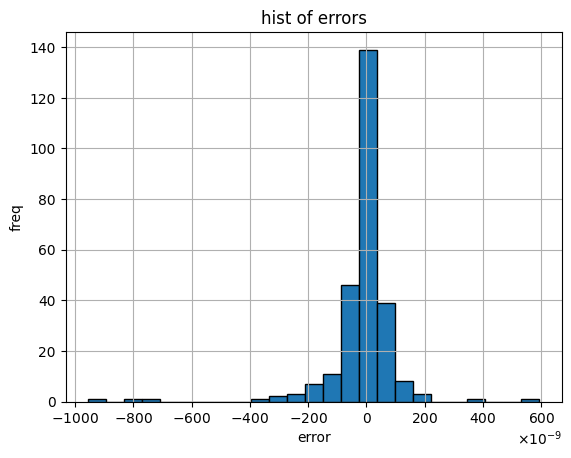

mu_error: -1.4574160837955972e-08,      sigma_error : 1.2243322039824937e-07


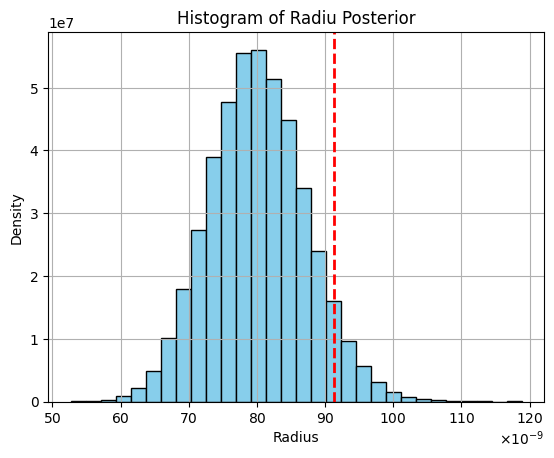

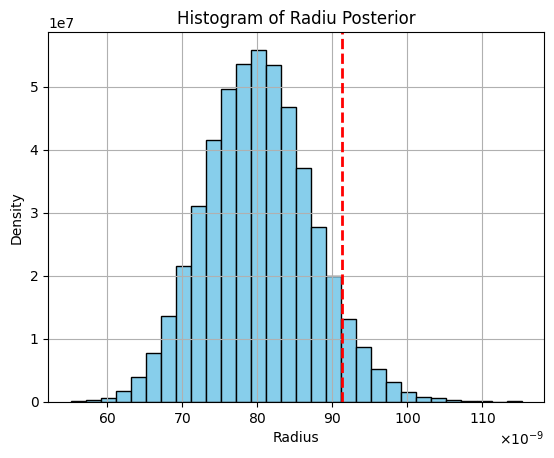

Particle 12, detections : 133
Minimum distance: 1.3654173492938606e-07


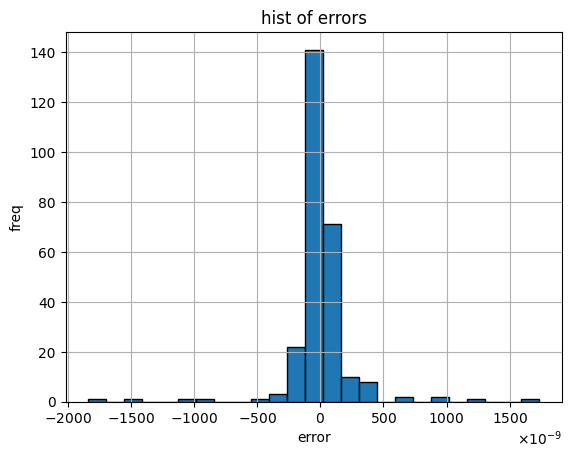

mu_error: 1.224387722770063e-09,      sigma_error : 2.582743484116795e-07


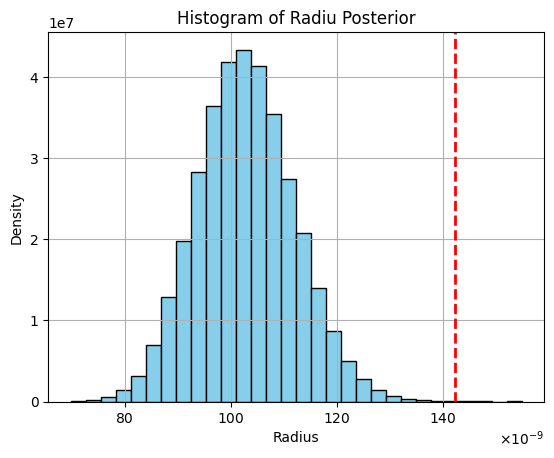

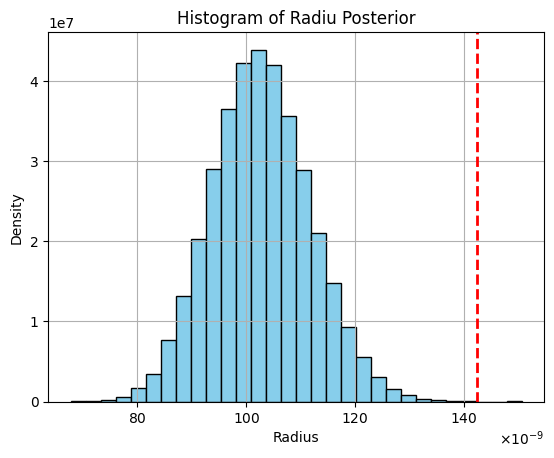

Particle 13, detections : 134
Minimum distance: 2.368266485927849e-07


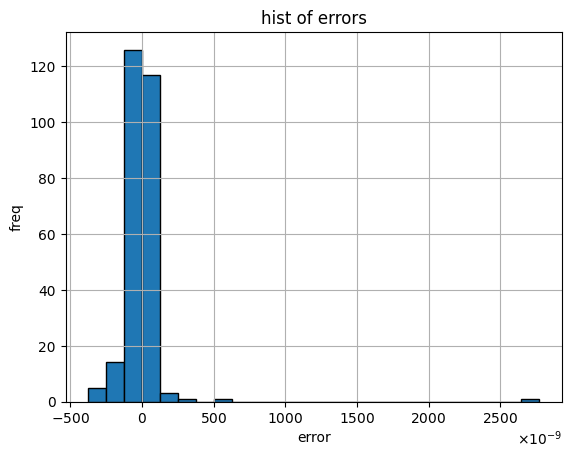

mu_error: 6.435750292309435e-10,      sigma_error : 1.891462789099835e-07


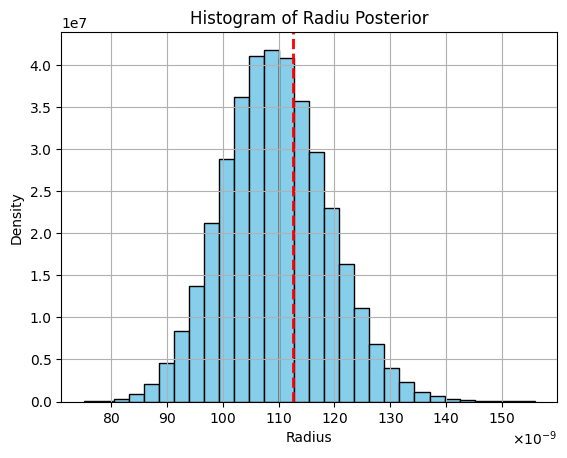

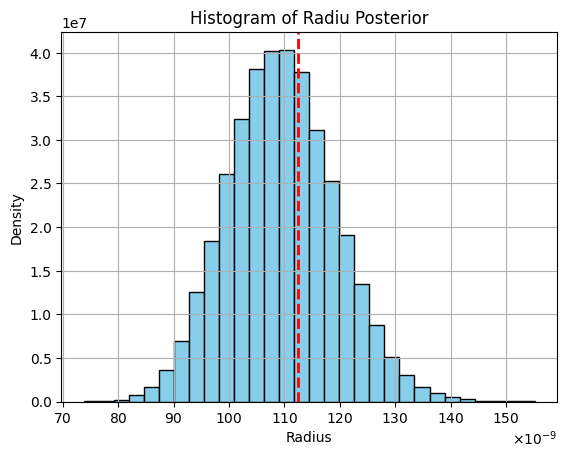

Particle 15, detections : 129
Minimum distance: 6.634343486396072e-08


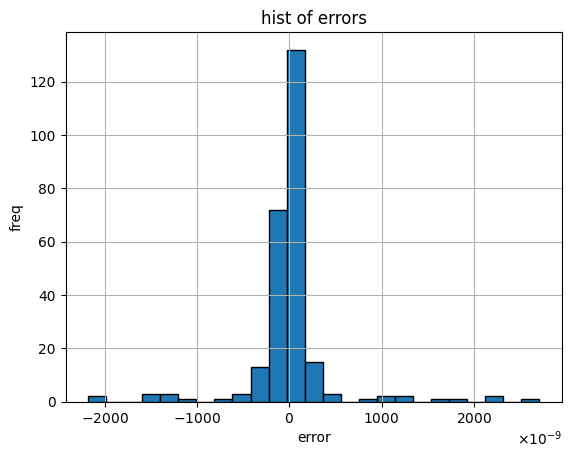

mu_error: -4.7195778401910504e-09,      sigma_error : 4.6877889677391035e-07


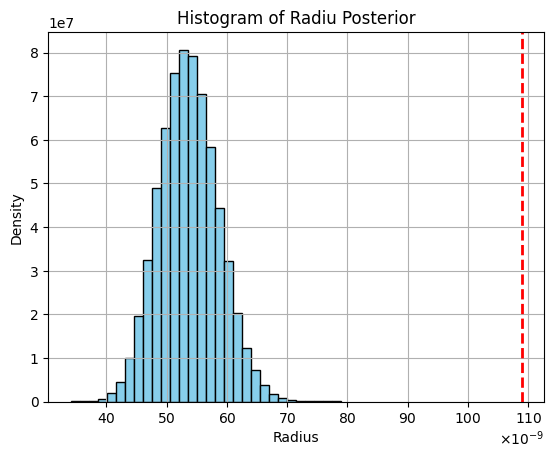

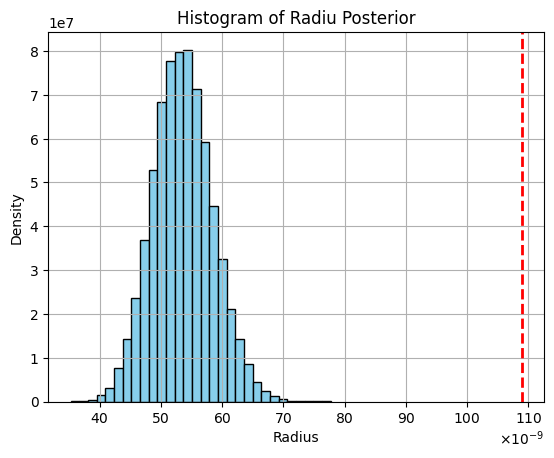

Particle 403, detections : 59


ValueError: can only convert an array of size 1 to a Python scalar

In [78]:

for tp_particle_num in tracks['particle'].unique():
    tp_track = tp_converted[tp_converted['particle'] == tp_particle_num]

    print(f"Particle {tp_particle_num}, detections : {len(tp_track)}")

    # get ground info (based on first trackPy frame with all particles)
    gnd_num, true_radius = get_ground_info(tp_track, ground, full_frame)


    # get error fit
    mu_error, sigma_error = get_error_info(tp_track, ground, gnd_num)
    print(f"mu_error: {mu_error},      sigma_error : {sigma_error}")


    ## run MCMC with estimated sigma_e2
    run_MCMC_with_error(tp_track, sigma_e2, true_radius, C, show_summary=False)

    ## run MCMC with no error consideration
    run_MCMC_with_error(tp_track, 0, true_radius, C, show_summary=False)



# 3D Patch Visualization for Deep Validation

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

def compare_patches_3d(real_frame, sim_frame, x, y, radius=20):
    """
    Given a real and simulated frame, and (x, y) coordinates,
    extract patches and display them side-by-side in 3D.
    """
    # Patch bounds
    x_min = max(0, int(x - radius))
    x_max = min(real_frame.shape[1], int(x + radius + 1))
    y_min = max(0, int(y - radius))
    y_max = min(real_frame.shape[0], int(y + radius + 1))

    # Real patch
    Z_real = real_frame[y_min:y_max, x_min:x_max]
    Z_sim = sim_frame[y_min:y_max, x_min:x_max]

    # Meshgrid
    X = np.arange(0, Z_real.shape[1])
    Y = np.arange(0, Z_real.shape[0])
    X, Y = np.meshgrid(X, Y)

    # Plot
    fig = plt.figure(figsize=(14, 6))

    ax1 = fig.add_subplot(1, 2, 1, projection='3d')
    ax1.plot_surface(X, Y, Z_real, cmap='viridis', edgecolor='none')
    ax1.set_title('Real Patch')

    ax2 = fig.add_subplot(1, 2, 2, projection='3d')
    ax2.plot_surface(X, Y, Z_sim, cmap='viridis', edgecolor='none')
    ax2.set_title('Simulated Patch')

    plt.show()

In [ ]:
# 1) particle ID and how many times they appear
particle_counts = tracks['particle'].value_counts()
print("Top 10 particles by track length:")
print(particle_counts.head(10))

# 2) longest particle that exists
best_particle = particle_counts.idxmax()
print(f"\nUsing particle_id = {best_particle} which appears in {particle_counts.max()} frames")

# 3) list frames
valid_frames = tracks.loc[tracks['particle']==best_particle, 'frame'].unique()
print("Some example frames for this particle:", valid_frames[:5])

# 4) compare frames
pid      = best_particle
frame_id = valid_frames[0]   #  any element from valid_frames

# extract its (x,y)
row = tracks[(tracks['particle']==pid) & (tracks['frame']==frame_id)].iloc[0]
x, y = row['x'], row['y']

# compare
compare_patches_3d(
    real_frame=np.asarray(test[frame_id]),
    sim_frame =np.asarray(sim [frame_id]),
    x=x, y=y, radius=20
)


In [ ]:
for particle in tracks['particle'].unique():
    #print(particle)
    particle_df = tracks[tracks["particle"] == particle]

    #plt.plot(particle_df['frame'], particle_df['signal'])
    #plt.show()

In [ ]:
curr_particle = 5
particle_df = strong_tracks[strong_tracks["particle"] == 5]

for frame_num in range(0, 30):
    #display_particle(strong_tracks, test[frame_num], curr_particle, frame_number=frame_num, radius=20)
    pass

In [ ]:
display_particle(tracks, sim[0], particle_number=2, frame_number=0, radius=20)